# Prediction de la confusion d'un individu grâce à des données EEG

On s'intéresse ici à tester différentes approches pour classifier un signal EEG.

In [3]:
import numpy as np # linear algebra
import pandas as pd
import random as rd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report 
from sklearn.svm import LinearSVC
from sklearn import metrics


import torch

import warnings
warnings.filterwarnings('ignore')


## A/ importation des données 

In [4]:
#starting the project
eeg_data = pd.read_csv('archive/EEG_data.csv')
info_data=pd.read_csv('archive/demographic_info.csv')
eeg_data.head()


,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [5]:

#on veut que chaque couple (sujet,video) soit un objet x
#les objets x sur lesquels on va travailler sont des matrices de taille (c,t) avec c le nombre de channels et t le nombre de points d'acquisition

#recuperation des valeurs de la colonne SubjectID
val_subjects = eeg_data['SubjectID'].unique()
val_videos = eeg_data['VideoID'].unique()

XY = []
for val1 in val_subjects:
    for val2 in val_videos:
        Xeeg_data = eeg_data[eeg_data['SubjectID']==val1]
        Xeeg_data = Xeeg_data[eeg_data['VideoID']==val2]
        y = Xeeg_data[['SubjectID','VideoID', 'predefinedlabel', 'user-definedlabeln']].head(1).to_numpy()
        y = y[0]
        Xeeg_data = Xeeg_data.drop(['SubjectID','VideoID','predefinedlabel', 'user-definedlabeln'],axis=1)
        Xeeg_data = Xeeg_data.to_numpy()
        xy = Xeeg_data, y
        XY.append(xy)
        



## B/ Première visualisation des données.

### Pour 1 individu, représenter le signal en fonction du temps 

In [6]:
X = XY[0][0]
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X-mean)/std


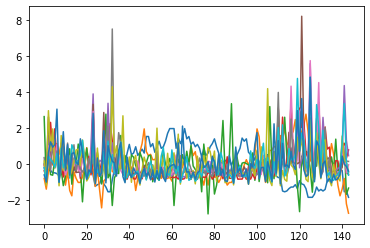

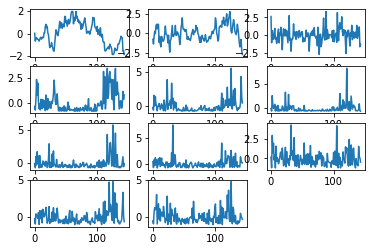

In [7]:
for i in range(X.shape[1]):
    x = X[:,i]
    plt.plot(x)
plt.show() 

#même chose mais en affichant les courbes côte à côte pour chaque channel
for i in range(X.shape[1]):
    x = X[:,i]
    plt.subplot(4,3,i+1)
    plt.plot(x)



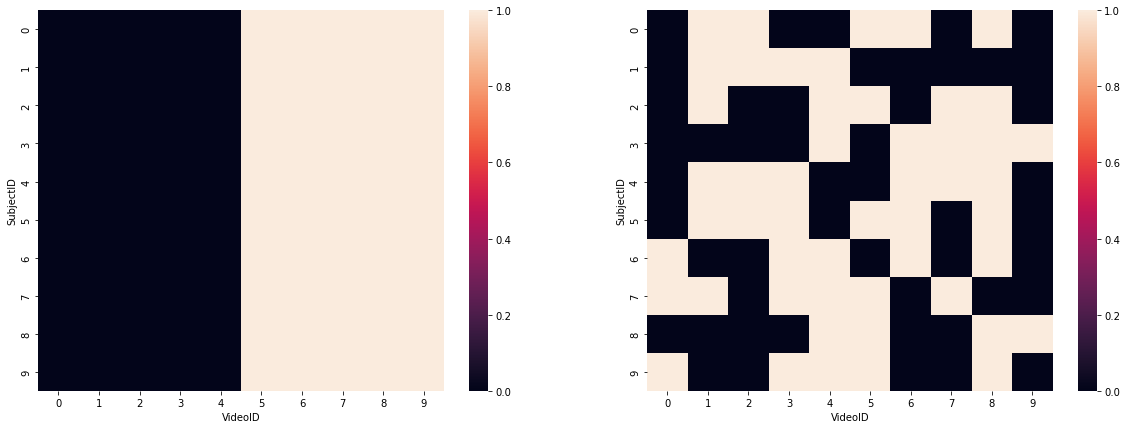

In [8]:
#regarder la distribution des 0 et des 1 par individus et par vidéos 
Obj_confusion_matrix = np.zeros((10,10))
Sub_confusion_matrix = np.zeros((10,10))
for x,y in XY:
    Row_index = int(y[0])
    Col_index = int(y[1])
    Obj_confusion_matrix[Row_index][Col_index] = y[2]
    Sub_confusion_matrix[Row_index][Col_index] = y[3]

fig, ax = plt.subplots(1,2,figsize=(20,7))
sns.heatmap(Obj_confusion_matrix,ax=ax[0])
sns.heatmap(Sub_confusion_matrix,ax=ax[1])
ax[0].set_xlabel('VideoID')
ax[0].set_ylabel('SubjectID')
ax[1].set_xlabel('VideoID')
ax[1].set_ylabel('SubjectID')
plt.show()



In [9]:
# #on regarde les corrélations entre la target et les données (heatmap)

# plt.figure(figsize = (15,15))
# cor_matrix = XY.corr()
# sns.heatmap(cor_matrix,annot=True)

## C/ prétraitements / Feature engineering

On va tester plusieurs manières différentes de traiter les n channels:
* concaténation pour former des matrices de n colonnes 
* concatenation pour former un seul channel n fois plus long
* channel par channel (puis méthode d'ensemble)

In [10]:
# for next time : trouver une méthode qui permettent de pas avoir à switcher entre les pack et unpack (ou méthode équivalente d'un module)
def unpacking(XY):
    X,Y = [],[]
    for x,y in XY:
        X.append(x)
        Y.append(y)
    return X,Y

def packing(X,Y):
    for i in range(len(X)):
        XY.append((X[i],Y[i]))
    return XY


In [11]:
#randomisation du jeu de données
def shuffle(data):
    return rd.shuffle(data)



#on garde seulement la target qui nous intéresse (en priorité le 'user-definedlabeln' )
def select_target(Y):
    new_Y = []
    for y in Y:
        y = y[3]
        new_Y.append(y)
    return new_Y

# Normalisation par channels (mais attention, si on normalise pour chaque enregistrement on perd de l'information, il faut normaliser avant, sur tout le channel enregistrer ?)

# normalized_XY = []
# for x,y in XY:
#     mean = x.mean(axis=0)
#     std = x.std(axis=0)
#     x = (x-mean)/(std+0.00000001)
#     normalized_XY.append((x,y))

# diminution du bruit (binning)


#### Feature engineering

In [27]:
#Ordre des colonnes (Attention, Mediation, Raw, Delta, Theta, Alpha1, Alpha2, Beta1, Beta2, Gamma1, Gamma2)


#on prend d'abord uniquement le signal theta et on prend les valeurs annoncées objectivement par les étudiants 
def select_colonne(X,i):
    new_X = []
    for x in X:
        x = x[:,i]
        new_X.append(x)
    return new_X


# use of tsfel library for feature extraction
import tsfel
def features_extraction(fX):
    fX = pd.DataFrame(np.hstack(fX))
    
    cfg_file = tsfel.get_features_by_domain('temporal')                                                        # If no argument is passed retrieves all available features
    X_train = tsfel.time_series_features_extractor(cfg_file, fX, window_size=100, verbose=0)
    return X_train




In [13]:
#création de variables d'intérets à partir du signal
#on va prendre la moyenne et la variance de chaque signal
#on va aussi prendre la moyenne et la variance de la dérivée du signal
def features_crea(X):
    features = np.empty((0,2))
    for signal in X:
        mean = signal.mean()
        std = signal.std()
        features = np.append(features,[[mean,std]],axis=0)
        # deriv = np.diff(signal)
        # signal = np.append(signal,mean)
        # signal = np.append(signal,std)
        # deriv = np.diff(signal)
        # mean = deriv.mean()
        # std = deriv.std()
    return features

### run pretraitement

In [ ]:
shuffle(XY)
X,Y = unpacking(XY)
fY = select_target(Y)
fX = select_colonne(X,4)

# les deux boucles for sont à mettre dans la fonction de features_extraction
#on créé la matrice features qui representent chaque enregistrement grâce à des caractéristiques du signal
features = []
for x in fX:
    one_seq_features = features_extraction(x)
    one_seq_features = np.array(one_seq_features).flatten()
    features.append(one_seq_features)
features = np.array(features)

#on normalise la matrice features par colonne
mean = features.mean(axis=0)
std = features.std(axis=0)
features = (features-mean)/(std+0.00000001)


X_train, X_test, y_train, y_test = train_test_split(features, fY, test_size=0.33, random_state=2022)

In [43]:

print(X_train)

[[-0.67422528 -0.41741972 -0.67422528 ... -0.52474352 -0.67422528
   0.        ]
 [-0.29566412 -0.01741296 -0.29566412 ...  0.05639553 -0.29566412
   0.        ]
 [-0.69765414 -0.49400784 -0.69765414 ... -0.54975432 -0.69765414
   0.        ]
 ...
 [-0.32945653  0.0453678  -0.32945653 ... -0.20843179 -0.32945653
   0.        ]
 [ 1.01346852  0.99349571  1.01346852 ...  1.06327583  1.01346852
   0.        ]
 [-1.09251343 -1.72083393 -1.09251343 ... -1.71925851 -1.09251343
   0.        ]]


## D/ Algorithmes supervisés

## SVM

In [54]:
SVMmod = LinearSVC()
SVMmod.fit(X_train,y_train)

y_hat = SVMmod.predict(X_test)
metrics.accuracy_score(y_test,y_hat)

0.5151515151515151

## CNN 

Attention, notre jeu de donnée ne comportant pas beaucoup d'exemples en comparaison avec la dimension des objets, il va falloir faire très attention au surapprentissage. 

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import time
import os
from torch.utils.data import TensorDataset, DataLoader,Dataset
import matplotlib.pyplot as plt




class EEGDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = X.shape[0]
    def __getitem__(self, index):
        x = torch.from_numpy(self.X[index])
        y = torch.from_numpy(np.array(self.Y[index]))
        return x,y
    def __len__(self):
        return self.len

## D/ Classification non supervisée:

--> définition de métriques différentes entre 2 enregistrements 
--> 